#### Import packages

In [1]:
#pip install numpy==1.20.3
#pip install tensorflow

In [2]:
#pip install pyopenssl --upgrade

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report

c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\monga\AppData\Roaming\Python\Python38\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
So

#### Import Data

In [4]:
import os 
os.listdir('data/')

['Credit data.csv', 'hmeq.csv']

In [5]:
#import credit data
'''
http://www.creditriskanalytics.net/datasets-private2.html
'''
cred_data = pd.read_csv('data/hmeq.csv')
cred_data.head()

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

In [6]:
cred_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


#### Exploratory Data Analysis

In [7]:
# Check for missing values
missing_values = cred_data.isnull().sum()
print(missing_values)

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64


> In this project, we assume that lack of data (missing entries) implies that a user does not have the underlying information. Therefore, missing entries are filled with 0 to avoid introducing bias by imputation

In [8]:
cred_data['REASON'].value_counts()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [9]:
# fill 0 for numeric columns and mode for categorical columns
for col in cred_data.columns:
    if cred_data[col].dtype == 'object':
        cred_data[col] = cred_data[col].fillna('Other')
    else:
        cred_data[col] = cred_data[col].fillna(0)
cred_data = cred_data.fillna(0)
# Check for missing values
missing_values = cred_data.isnull().sum()
print(missing_values)

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64


In [10]:

# Convert the "BAD" variable to categorical
# Convert "BAD" to "risk" if 1 and "non-risk" if 0
cred_data['BAD'] = cred_data['BAD'].map({1: 'risk', 0: 'non-risk'})
cred_data['BAD'] = cred_data['BAD'].astype('category')

In [11]:
# Check for outliers
numeric_cols = cred_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
#print(cred_data[numeric_cols].describe())

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(16, 4))

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(cred_data[col], vert=False)
    axes[i].set_title(col)

plt.show()

> There are some outliers in the data. Dropping them might lead to loss of important information. As such, we will treat the outliers by first conducting log transformatoion then winsorizing them (replacing the extreme values with the nearest value within a certain range. This approach can help preserve the overall distribution of the data while reducing the impact of extreme values.)

In [12]:
# Transform data using log transformation
import numpy as np

cred_data[numeric_cols] = cred_data[numeric_cols].apply(lambda x: np.log(x + 1))
# Check for outliers
numeric_cols = cred_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
#print(cred_data[numeric_cols].describe())

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(16, 4))

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(cred_data[col], vert=False)
    axes[i].set_title(col)

plt.show()

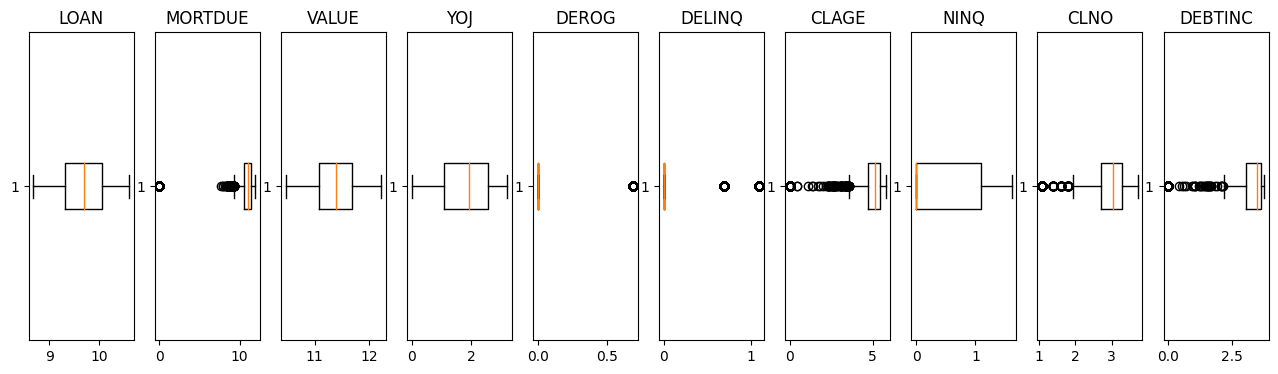

In [13]:
# Winsorize outliers based on IQR range
from scipy.stats.mstats import winsorize

for col in numeric_cols:
    cred_data[col] = winsorize(cred_data[col], limits=[0.05, 0.05])
    
# Check for outliers
numeric_cols = cred_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
#print(cred_data[numeric_cols].describe())

fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(16, 4))

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(cred_data[col], vert=False)
    axes[i].set_title(col)

plt.show()

#### Check Distribution of the target attribute

In [14]:
# Plot distribution of "BAD"
sns.countplot(data=cred_data, x='BAD')
plt.grid()

# Add percentage labels
total = len(cred_data['BAD'])
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.gca().annotate(percentage, (x, y))
plt.title("Distribution of credit holders who are risky and who are not-risky")
plt.show()

### Fit a deep learning model

#### Using the imbalanced data

In [15]:
#Convert categorical variables to bianry (dummy)
cred_data_df = pd.get_dummies(cred_data, columns=cred_data.select_dtypes(include = [object]).columns)
#Convert target to binary
cred_data_df['BAD'] = cred_data_df['BAD'].replace({'risk': 1, 'non-risk': 0})
cred_data_df.head()

BAD      LOAN    MORTDUE      VALUE       YOJ  DEROG    DELINQ     CLAGE  \
0   1  8.682877  10.160491  10.571983  2.442347    0.0  0.000000  4.557729   
1   1  8.682877  11.157022  11.133143  2.079442    0.0  1.098612  4.810828   
2   1  8.682877   9.510519  10.468347  1.609438    0.0  0.000000  5.013742   
3   1  8.682877   0.000000  10.468347  0.000000    0.0  0.000000  0.000000   
4   0  8.682877  11.490690  11.626263  1.386294    0.0  0.000000  4.546835   

       NINQ      CLNO  DEBTINC  REASON_DebtCon  REASON_HomeImp  REASON_Other  \
0  0.693147  2.302585      0.0               0               1             0   
1  0.000000  2.708050      0.0               0               1             0   
2  0.693147  2.397895      0.0               0               1             0   
3  0.000000  1.098612      0.0               0               0             1   
4  0.000000  2.708050      0.0               0               1             0   

   JOB_Mgr  JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
0        0           0          1            0          0         0  
1        0           0          1            0          0         0  
2        0           0          1            0          0         0  
3        0           0          1            0          0         0  
4        0           1          0            0          0         0

In [16]:
cred_data_df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'REASON_DebtCon', 'REASON_HomeImp',
       'REASON_Other', 'JOB_Mgr', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self'],
      dtype='object')

In [16]:
cred_data_df.to_csv("data/Credit data.csv")

> Ideally, we want to minimize the number of false negatives (individuals who are risky but are flagged as not risky). The best metric with which to evaluate the model in such as a case is the Recall (also known as sensitivity) which is the proportion of positive cases (i.e., cases with a 'BAD' value of 1) that the model correctly identified as positive. Recall is better than precision when the cost of false negatives (i.e., incorrectly identifying a positive case as negative) is higher than the cost of false positives (i.e., incorrectly identifying a negative case as positive). We assume that the cost of giving a loan to an individual who is likely to default is higher than the cost of denying a loan and subjecting the individual to more attempts.

In [20]:
X_train.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'REASON_DebtCon', 'REASON_HomeImp', 'REASON_Other',
       'JOB_Mgr', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales',
       'JOB_Self'],
      dtype='object')

In [23]:
X_train

LOAN    MORTDUE      VALUE       YOJ     DEROG    DELINQ     CLAGE  \
402    8.779711  10.853697  11.382486  1.609438  0.000000  0.000000  5.348660   
3350   9.787010  11.515702  12.005809  0.000000  0.693147  0.000000  5.552395   
5916  10.596660  11.150362  11.877062  2.564949  0.000000  0.000000  4.781260   
8273  10.509886  11.911708  12.220444  1.615339  0.000000  0.000000  5.288232   
5653  10.589132  11.893702  12.220444  1.791759  0.000000  0.000000  4.944757   
...         ...        ...        ...       ...       ...       ...       ...   
8981   8.983041   0.000000  10.549214  2.023838  0.000000  0.000000  3.146528   
6400   8.682877  10.575194  10.548103  1.019229  0.000000  0.151811  4.989044   
9160   8.716505   0.000000  11.605237  2.942057  0.000000  0.944626  4.848259   
1688   9.384378  11.276697  11.555717  0.693147  0.000000  0.000000  4.383044   
5994   9.560835  11.856285  12.007974  2.549712  0.000000  0.775139  5.128718   

          NINQ      CLNO   DEBTINC  REASON_DebtCon  REASON_HomeImp  \
402   1.609438  3.401197  3.445005               1               0   
3350  0.000000  3.218876  3.620441               0               0   
5916  0.000000  2.484907  3.712971               0               1   
8273  0.000000  3.091042  3.768728               1               0   
5653  0.000000  3.465736  3.596193               0               1   
...        ...       ...       ...             ...             ...   
8981  1.031962  1.098612  0.000000               0               1   
6400  0.693147  2.708050  0.000000               0               1   
9160  0.097154  2.761732  0.000000               0               1   
1688  0.693147  3.178054  3.714162               1               0   
5994  0.552982  3.490285  0.000000               1               0   

      REASON_Other  JOB_Mgr  JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  \
402              0        0           0          1            0          0   
3350             1        0           0          1            0          0   
5916             0        0           1          0            0          0   
8273             0        0           0          0            1          0   
5653             0        0           0          0            1          0   
...            ...      ...         ...        ...          ...        ...   
8981             0        0           0          1            0          0   
6400             0        0           0          1            0          0   
9160             0        0           0          1            0          0   
1688             0        1           0          0            0          0   
5994             0        1           0          0            0          0   

      JOB_Self  
402          0  
3350         0  
5916         0  
8273         0  
5653         0  
...        ...  
8981         0  
6400         0  
9160         0  
1688         0  
5994         0  

[6679 rows x 19 columns]

In [17]:
%%time
# Define input and output variables
X = cred_data_df.drop(['BAD'], axis=1)
y = cred_data_df['BAD']
#Oversample to ensure data balancing
from imblearn.over_sampling import SMOTE
sampler = SMOTE()
X_t, y_t = sampler.fit_resample(X, y)
#split data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size = 0.3, random_state = 3)
#to ensure the results are the same after each training, we set a random seed
tf.random.set_seed(42)
# Define model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
tf.random.set_seed(42)
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(thresholds = 0.1), 
                                                                     tf.keras.metrics.AUC()])
tf.random.set_seed(42)
# Train model
history = model.fit(X_train, y_train, epochs = 20, validation_split = 0.2, verbose = 0)

# Evaluate model on test data
loss, recall, auc = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test recall', recall)
print('Test auc', auc)

90/90 [==============================] - 1s 6ms/step - loss: 0.4458 - recall: 0.9986 - auc: 0.8732
Test loss: 0.4458158612251282
Test recall 0.9985945224761963
Test auc 0.8731575012207031
CPU times: total: 28 s
Wall time: 28 s


In [18]:
# Save the model
model.save('model1.h5')

In [19]:
from tensorflow.keras.models import load_model

# Load the model
modell = load_model('model1.h5')

# Make predictions on new data
predictions = modell.predict(X_test)

# Print the predictions
# Define a threshold value
threshold = 0.1

# Convert the predictions to binary values
binary_predictions = (predictions >= threshold).astype(int)

# Print the binary predictions
#print(binary_predictions)

90/90 [==============================] - 0s 1ms/step


In [20]:
predictions = model.predict(X_test)
# Define a threshold value
threshold = 0.1

# Convert the predictions to binary values
binary_predictions = (predictions >= threshold).astype(int)

print(classification_report(binary_predictions, y_test))

90/90 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.10      0.99      0.17       138
           1       1.00      0.52      0.69      2725

    accuracy                           0.54      2863
   macro avg       0.55      0.76      0.43      2863
weighted avg       0.96      0.54      0.66      2863



In [21]:
modell.evaluate(X_test, y_test)

90/90 [==============================] - 0s 1ms/step - loss: 0.4295 - recall: 0.9993 - auc: 0.8848


[0.4294917583465576, 0.9992972612380981, 0.8847939372062683]

#### Optimize the model


> To optimize the model, the complexity of the model will be taken into consideration

In [37]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size = 0.3, random_state = 42)
#define callbacks to stp the model if it is not improving
from keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Recall(thresholds = 0.1), tf.keras.metrics.AUC(from_logits=True)])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               5120      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 4)                

In [38]:
# fit the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks = early_stop)

# Evaluate model on test data
loss, recall, auc = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test recall', recall)
print('Test auc', auc)

Epoch 1/50
167/167 [==============================] - 6s 8ms/step - loss: 0.5425 - recall_2: 0.9981 - auc_2: 0.8033 - val_loss: 0.5253 - val_recall_2: 0.9849 - val_auc_2: 0.8460
Epoch 2/50
167/167 [==============================] - 1s 5ms/step - loss: 0.4597 - recall_2: 0.9921 - auc_2: 0.8571 - val_loss: 0.4938 - val_recall_2: 0.9849 - val_auc_2: 0.8557
Epoch 3/50
167/167 [==============================] - 1s 4ms/step - loss: 0.4442 - recall_2: 0.9929 - auc_2: 0.8692 - val_loss: 0.5174 - val_recall_2: 1.0000 - val_auc_2: 0.8584
Epoch 4/50
167/167 [==============================] - 1s 3ms/step - loss: 0.4425 - recall_2: 0.9959 - auc_2: 0.8726 - val_loss: 0.4600 - val_recall_2: 0.9970 - val_auc_2: 0.8658
Epoch 5/50
167/167 [==============================] - 1s 3ms/step - loss: 0.4227 - recall_2: 0.9917 - auc_2: 0.8858 - val_loss: 0.4971 - val_recall_2: 0.9970 - val_auc_2: 0.8649
Epoch 6/50
167/167 [==============================] - 1s 3ms/step - loss: 0.4224 - recall_2: 0.9887 - auc_2: 0

#### Model Evaluation

In [40]:
preds = model.predict(X_test)
# Convert the predictions to binary values
binary_predictions = (preds >= 0.3).astype(int)
print(classification_report(binary_predictions, y_test))

90/90 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.56      0.91      0.69       872
           1       0.94      0.68      0.79      1991

    accuracy                           0.75      2863
   macro avg       0.75      0.80      0.74      2863
weighted avg       0.83      0.75      0.76      2863



In [25]:
model.save("amod.h5", save_format="h5")

In [26]:
preds = model.predict(X_test)

90/90 [==============================] - 0s 2ms/step


In [27]:
modell = tf.keras.models.load_model('amod')

In [28]:
modell.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               5120      
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 8)                 136       
                                                                 
 dense_30 (Dense)            (None, 4)                

In [55]:
preds = model.predict(X_test)
# Convert the predictions to binary values
binary_predictions = (preds1 >= 0.3).astype(int)
print(classification_report(binary_predictions, y_test))

90/90 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.56      0.91      0.69       872
           1       0.94      0.68      0.79      1991

    accuracy                           0.75      2863
   macro avg       0.75      0.80      0.74      2863
weighted avg       0.83      0.75      0.76      2863



#### Cost (Profit/Loss) from the model

> To compute the profit/loss of giving an individual 100000 using the recall score and confusion matrix, we need to make some assumptions about the costs and benefits associated with each possible outcome. The following assumptions are made:

- If the model predicts that an individual will default and they actually default, the bank does not offer a loan
- If we predicts that an individual will not default and they actually default, the bank loses the entire loan amount
- If we predicts that an individual will default and they actually do not default, then the bank gains 0 since no loan is given
- If we predicts that an individual will not default and they actually do not default, the bank gains the loan amount plus additional interest (assume 14%)

First, we define a confusion matrix which provides us with information like:

1. True Positive (TP): The number of positive examples that were correctly classified as positive by the model.
2. False Positive (FP): The number of negative examples that were incorrectly classified as positive by the model.
3. True Negative (TN): The number of negative examples that were correctly classified as negative by the model.
4. False Negative (FN): The number of positive examples that were incorrectly classified as negative by the model.


Based on the predictions, customers who are predicted that they will not default and they do not default are given a loan, those that are predicted to default but they do not default are not given a loan, those that are predicted that they will not default but they default are given a loan, those that are predicted that they will default and they default are not given a loan. Each customer is assumed to be given a 1000 dollar loan.

Using this information, we will compute the profit/loss as a result of adopting the model.

In [57]:
#Compute the expected cost of the model
def compute_profit(predictions, loan_amount=1000, interest_rate=0.14):
    confusion_mat = confusion_matrix(y_test, predictions)
    # Get the number of true/false positives/negatives from the confusion matrix
    tn, fp, fn, tp = confusion_mat.ravel()

    # Compute the total amount of money loaned out
    total_loan_amount = loan_amount * (tn + fp + fn)

    # Compute the total interest gained if all customers pay back their loans
    total_interest_gained = total_loan_amount * interest_rate

    # Compute the cost due to false negatives
    cost_fn = fn * loan_amount

    # Compute the net profit/loss
    net_profit_loss = total_interest_gained - cost_fn

    return round(net_profit_loss, 2)


#determine the optimal threshold fo determining risk
def optim_theshold(threshold):
    binary_predictions = (preds >= threshold).astype(int)
    #print(classification_report(binary_predictions, y_test))
    from sklearn.metrics import confusion_matrix
    # Generate a confusion matrix
    confusion_mat = confusion_matrix(y_test, binary_predictions)
    print("===================")
    print("Threshold:", threshold)
    #print(confusion_mat)
    TP = confusion_mat[0][0]
    print('True positives:', TP)
    FN = confusion_mat[0][1]
    print('False negatives:', FN)
    FP = confusion_mat[1][0]
    print('False positives:', FP)
    TN = confusion_mat[1][1]
    print('True negatives:', TN)
    print('\n')


    #specify the loan given
    loan = 1000

    profit = compute_profit(binary_predictions, loan_amount=loan, interest_rate=0.14)
    
    return profit

In [58]:
from sklearn.metrics import confusion_matrix
profits = []
thresholds = []
for thres in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    profit = optim_theshold(thres)
    profits.append(profit)
    thresholds.append(thres)
    
#thresholds and profits
thresh = pd.DataFrame()
thresh['Threshold'] = thresholds
thresh['Profit'] = profits
thresh.sort_values('Profit', ascending = False)

Threshold: 0.1
True positives: 270
False negatives: 1149
False positives: 6
True negatives: 1438


Threshold: 0.2
True positives: 603
False negatives: 816
False positives: 31
True negatives: 1413


Threshold: 0.3
True positives: 791
False negatives: 628
False positives: 81
True negatives: 1363


Threshold: 0.4
True positives: 968
False negatives: 451
False positives: 123
True negatives: 1321


Threshold: 0.5
True positives: 1083
False negatives: 336
False positives: 173
True negatives: 1271


Threshold: 0.6
True positives: 1216
False negatives: 203
False positives: 273
True negatives: 1171


Threshold: 0.7
True positives: 1276
False negatives: 143
False positives: 385
True negatives: 1059


Threshold: 0.8
True positives: 1332
False negatives: 87
False positives: 533
True negatives: 911


Threshold: 0.9
True positives: 1379
False negatives: 40
False positives: 710
True negatives: 734




Threshold    Profit
0        0.1  193500.0
1        0.2  172000.0
2        0.3  129000.0
3        0.4   92880.0
4        0.5   49880.0
5        0.6  -36120.0
6        0.7 -132440.0
7        0.8 -259720.0
8        0.9 -411940.0

In [59]:
# Save the model
model.save('credit_prediction_model.h5')

In [77]:
X_test.iloc[1:3,].T

1851       4416
LOAN             9.425532  10.043293
MORTDUE         11.911708   0.000000
VALUE           12.220444  10.940065
YOJ              2.302585   0.000000
DEROG            0.000000   0.000000
DELINQ           0.000000   0.693147
CLAGE            5.368102   5.753441
NINQ             0.000000   0.000000
CLNO             3.135494   2.995732
DEBTINC          3.545255   3.656969
REASON_DebtCon   0.000000   1.000000
REASON_HomeImp   1.000000   0.000000
REASON_Other     0.000000   0.000000
JOB_Mgr          0.000000   0.000000
JOB_Office       0.000000   0.000000
JOB_Other        0.000000   1.000000
JOB_ProfExe      1.000000   0.000000
JOB_Sales        0.000000   0.000000
JOB_Self         0.000000   0.000000

1/1 [==============================] - 0s 439ms/step


In [82]:
model.predict(X_test.iloc[2:3,])

1/1 [==============================] - 0s 73ms/step


array([[0.3302061]], dtype=float32)

In [84]:
X_test.iloc[2:3,].T

4416
LOAN            10.043293
MORTDUE          0.000000
VALUE           10.940065
YOJ              0.000000
DEROG            0.000000
DELINQ           0.693147
CLAGE            5.753441
NINQ             0.000000
CLNO             2.995732
DEBTINC          3.656969
REASON_DebtCon   1.000000
REASON_HomeImp   0.000000
REASON_Other     0.000000
JOB_Mgr          0.000000
JOB_Office       0.000000
JOB_Other        1.000000
JOB_ProfExe      0.000000
JOB_Sales        0.000000
JOB_Self         0.000000

In [81]:
model.predict(X_test.iloc[2:3,])

1/1 [==============================] - 0s 57ms/step


array([[0.3302061]], dtype=float32)

##### Define the user interface

In [12]:
#!pip install -U setuptools
#!pip install gradio==3.14.0 --user
#!pip uninstall websockets
#!pip install -U websockets

^C


In [1]:
import pandas as pd
import tensorflow as tf
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

# define the function to make predictions
def predict_loan_approval(loan_amount, mortdue, prop_value, reason, job, yoj, derog, delinq, clage, ninq, clno, debtinc):
    # load the input data into a pandas dataframe
    input_df = pd.DataFrame({
        "LOAN": [loan_amount],
        "MORTDUE": [mortdue],
        "VALUE": [prop_value],
        "REASON_DebtCon": [int("DebtCon" in reason)],
        "REASON_HomeImp": [int("HomeImp" in reason)],
        "REASON_Other" :[int("Other" in reason)],
        "JOB_Mgr": [int("Mgr" in job)],
        "JOB_Office": [int("Office" in job)],
        "JOB_ProfExe": [int("ProfExe" in job)],
        "JOB_Sales": [int("Sales" in job)],
        "JOB_Self": [int("Self" in job)],
        "JOB_Other": [int("Other" in job)],
        "YOJ": [yoj],
        "DEROG": [derog],
        "DELINQ": [delinq],
        "CLAGE": [clage],
        "NINQ": [ninq],
        "CLNO": [clno],
        "DEBTINC": [debtinc]
    })
    # add dummy variables for reason and job
    if "DebtCon" in reason:
        input_df["REASON_DebtCon"] = 1
    else:
        input_df["REASON_DebtCon"] = 0
    if "HomeImp" in reason:
        input_df["REASON_HomeImp"] = 1
    else:
        input_df["REASON_HomeImp"] = 0
        
    if "Mgr" in job:
        input_df["JOB_Mgr"] = 1
    else:
        input_df["JOB_Mgr"] = 0
    if "Office" in job:
        input_df["JOB_Office"] = 1
    else:
        input_df["JOB_Office"] = 0
    if "Other" in job:
        input_df["JOB_Other"] = 1
    else:
        input_df["JOB_Other"] = 0
    if "ProfExe" in job:
        input_df["JOB_ProfExe"] = 1
    else:
        input_df["JOB_ProfExe"] = 0
    if "Sales" in job:
        input_df["JOB_Sales"] = 1
    else:
        input_df["JOB_Sales"] = 0
    if "Self" in job:
        input_df["JOB_Self"] = 1
    else:
        input_df["JOB_Self"] = 0
    
    # load the pretrained model
    model = tf.keras.models.load_model("credit_prediction_model.h5")

    # make a prediction
    prediction = model.predict(input_df)
    pred = prediction[0][0]
    # return the prediction as "Approved" or "Not Approved"
    if pred  > 0.3:
        return "Risk score: "+str(round(pred))+" :Decision: "+"Not Approved"
    else:
        return str(round(pred,4))+":"+"Approved" 


# define the Gradio interface
inputs = [
    gr.inputs.Number(label="Loan Amount (000)"),
    gr.inputs.Number(label="Amount due on Existing Mortgage"),
    gr.inputs.Number(label="Value of Current Property"),
    gr.inputs.CheckboxGroup(
        label="Reason",
        choices=["DebtCon", "HomeImp"]
    ),
    gr.inputs.CheckboxGroup(
        label="Job",
        choices=['Office', 'Sales', 'Mgr', 'ProfExe', 'Self','Other']
    ),
    gr.inputs.Number(label="Years at Present Job"),
    gr.inputs.Number(label="Number of Major Derogatory Reports"),
    gr.inputs.Number(label="Number of Delinquent Credit Lines"),
    gr.inputs.Number(label="Age of Oldest Credit Line in Months"),
    gr.inputs.Number(label="Number of Recent Credit Inquiries"),
    gr.inputs.Number(label="Number of Credit Lines"),
    gr.inputs.Number(label="Debt-to-Income Ratio")
]

outputs = gr.outputs.Textbox(label="Loan Approval")

iface = gr.Interface(
    fn=predict_loan_approval,
    inputs=inputs,
    outputs=outputs,
    title="Loan Approval Prediction",
    description="Enter the details of the loan application to check for eligibility",
    theme="dark" # default theme
)
iface.launch(share=True)

c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\monga\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Running on local URL:  http://127.0.0.1:7860

Setting up a public link... we have recently upgraded the way public links are generated. If you encounter any problems, please report the issue and downgrade to gradio version 3.13.0
.

Could not create share link, please check your internet connection.


In [90]:
!jupyter nbconvert CreditDefaultPrediction.ipynb --to python

[NbConvertApp] Converting notebook CreditDefaultPrediction.ipynb to python
[NbConvertApp] Writing 17393 bytes to CreditDefaultPrediction.py
